
<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/Banner_IA2_1.png" style="width:1500px;heigth:100px">

# <center> **Taller 3** </center>



## Importar librerías

In [2]:
import os
import PIL
import cv2
import time
import glob
import imageio
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython import display
from itertools import chain
from google.colab import files
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from tensorflow.keras import layers
from skimage.morphology import label
from skimage.transform import resize
from tqdm import tqdm_notebook, tnrange
from keras.models import Model, load_model
from keras.layers.merge import concatenate, add
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow, concatenate_images
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"brayanbarajas","key":"93a4862dad3228477fd10131273d8d6b"}'}

In [3]:
!ls -lha kaggle.json
!mkdir -p ~/.kaggle/
!cp kaggle.json ~/.kaggle
# This permissions change avoids a warning on Kaggle tool startup
!chmod 600 ~/.kaggle/kaggle.json

-rw-r--r-- 1 root root 69 Mar 12 03:28 kaggle.json


# **1. Enjoy Autoencoders**

Implement a colorization autoencoder. For doing so, please use the selected image dataset in _Taller 1_ that reported in "DATASET-CNN-TL1" [Here](https://docs.google.com/spreadsheets/d/11aWNZ4OxuToIjJI5H6dyTtnQ3ne29D1pk56vNqtNMCs/edit#gid=0). 

- Compute grayscale images to whole dataset
- Implement autoencoder for color-gray couples. 
- Split the dataset in train (80%) and test (20%)
- Display some results and report some metric of performance. 

## Carga de dataset

In [4]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 8.8MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp37-none-any.whl size=73269 sha256=71ce27499c0d0ab10b254fa58b939c38f886731375e288ac60ac49bade41a363
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


In [4]:
#install in case it's not installed
#!pip install -q kaggle
!kaggle datasets download -d alexattia/the-simpsons-characters-dataset
!unzip the-simpsons-characters-dataset.zip -d /content/Data # cambiar el nombre de archivo .zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: /content/Data/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1270.jpg  
  inflating: /content/Data/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1271.jpg  
  inflating: /content/Data/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1272.jpg  
  inflating: /content/Data/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1273.jpg  
  inflating: /content/Data/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1274.jpg  
  inflating: /content/Data/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1275.jpg  
  inflating: /content/Data/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1276.jpg  
  inflating: /content/Data/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1277.jpg  
  inflating: /content/Data/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1278.jpg  
  inflating: /content/Data/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1279.jpg  
  inflating: /content/Data/simpsons_dataset/simpsons_datase

In [5]:
import os
os.chdir("Data")
!rm -r simpsons_dataset/simpsons_dataset/ #Eliminar una carpeta repetida

Se dejan todas las imágenes en una carpeta

In [6]:
import shutil
path="simpsons_dataset/"
classes=os.listdir(path)
class_sizes=[len(os.listdir("simpsons_dataset/"+c)) for c in classes]
#p_classes = [c for _,c in sorted(zip(class_sizes,classes))]
#p_classesg=p_classes[int(len(classes)/2)+1:]

#for i in p_classes[0:int(len(classes)/2)+1]:
#  shutil.rmtree(path+i)

os.makedirs("simpsons", exist_ok=True)
dest="simpsons"
classes=os.listdir(path)
cont=0
for i in classes:
  files = os.listdir(path+i)
  for f in files:
    cont+=1
    os.rename(path + i +"/"+ f,dest+"/"+str(cont)+".jpg")

In [7]:
import cv2
import matplotlib.pyplot as plt
path="simpsons/"

Se leen las imágenes en formato RGB y formato gray


In [8]:
files=os.listdir(path)
imgs_gray=[]
imgs_rgb=[]
for f in files: 
  x=cv2.imread(path+f)
  x=cv2.resize(x,(64,64))
  x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
  x2 = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)
  imgs_rgb.append(x)
  imgs_gray.append(x2)

Se selecciona el 80% para train

In [9]:
from sklearn.model_selection import train_test_split
imgs_gray1 = np.array(imgs_gray)
imgs_gray1 = np.expand_dims(imgs_gray1, axis=3)
imgs_rgb1 = np.array(imgs_rgb)
imgs_gray1 = imgs_gray1.astype('float32') / 255
imgs_rgb1 = imgs_rgb1.astype('float32') / 255
print(imgs_gray1.shape)
gray_train, gray_test, rgb_train, rgb_test = train_test_split(imgs_gray1, imgs_rgb1, test_size=0.2)

(20933, 64, 64, 1)


Se crea el autoencoder

In [10]:
input_img = tf.keras.layers.Input(shape=(64, 64, 1) ) 
x = tf.keras.layers.Conv2D(32, (5, 5), activation='relu', padding='same')(input_img)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x) #  (4, 4, 8)  128-dimensional

x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
decoded = tf.keras.layers.Conv2D(3, (5, 5), activation='sigmoid', padding='same')(x)

autoencoder_cnn = tf.keras.models.Model(input_img, decoded)
autoencoder_cnn.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        832       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        4624      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 16)        0     

In [13]:
opt = tf.optimizers.Adam(learning_rate = 0.001)
autoencoder_cnn.compile(optimizer=opt, loss='binary_crossentropy')
history = autoencoder_cnn.fit(gray_train, rgb_train,  epochs=100,
                batch_size=64, shuffle=True, 
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)])

# Encoder
encoder = tf.keras.models.Model(input_img, encoded)

encoded_imgs = encoder.predict(gray_test)
predicted = autoencoder_cnn.predict(gray_test)
predicted.shape

Epoch 1/100
262/262 [==============================] - 6s 20ms/step - loss: 0.5959
Epoch 2/100
262/262 [==============================] - 5s 20ms/step - loss: 0.5959
Epoch 3/100
262/262 [==============================] - 5s 20ms/step - loss: 0.5957
Epoch 4/100
262/262 [==============================] - 5s 20ms/step - loss: 0.5952
Epoch 5/100
262/262 [==============================] - 5s 20ms/step - loss: 0.5956
Epoch 6/100
262/262 [==============================] - 5s 20ms/step - loss: 0.5955
Epoch 7/100
262/262 [==============================] - 5s 20ms/step - loss: 0.5956
Epoch 8/100
262/262 [==============================] - 5s 20ms/step - loss: 0.5951
Epoch 9/100
262/262 [==============================] - 5s 20ms/step - loss: 0.5953
Epoch 10/100
262/262 [==============================] - 5s 20ms/step - loss: 0.5947
Epoch 11/100
262/262 [==============================] - 5s 20ms/step - loss: 0.5952
Epoch 12/100
262/262 [==============================] - 5s 20ms/step - loss: 0.5961
E

(4187, 64, 64, 3)

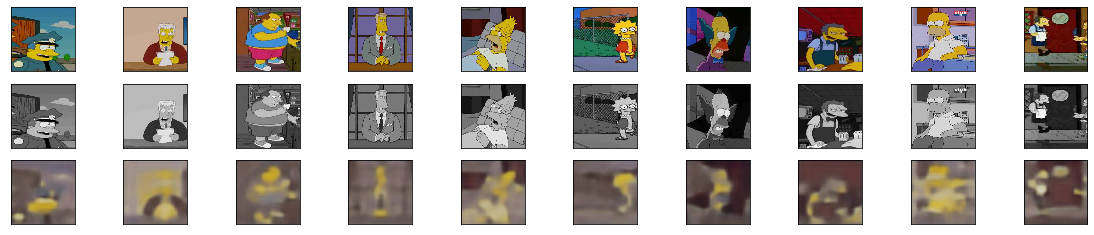

In [16]:
#@title **code** visualize the results
plt.figure(figsize=(40, 4))
for i in range(10):
    # display original
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(rgb_test[i].reshape(64, 64,3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display encoded image
    ax = plt.subplot(3, 20, i + 1 + 20)
    plt.imshow(gray_test[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(3, 20, 2*20 +i+ 1)
    plt.imshow(predicted[i].reshape(64, 64,3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

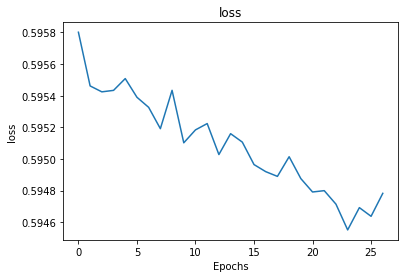

In [14]:
epochs=range(len(history.history['loss']))
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'])
plt.title('loss')
plt.xlabel("Epochs")
plt.ylabel('loss')
plt.show()

* La red creada tiene en sus extremos kernel de 5x5, así como se le agrega un dropout intermedio tanto en el encoder como el decoder. El learning rate utilizado fue de 0.001 y se utilizó una paciencia de 3 para detener el entrenamiento respecto al loss.

* Se ve cómo el loss disminuye en cada iteración pero de forma un poco errática, además de no disminuir considerablemenete. Además, como se trata de imágenes de los Simpson, no es tan sencillo el colorear debido a que la mayoría de imágenes se centran en el color amarillo característico de los personajes.

# **2. Enjoy UNET**

Seismic data is captured from seismic reflection reult useful to detect several areas of the world where there are vast quantities of salt in the subsurface. 
Propose a **UNET** architecture to automatically segment salt regions from seismic data. The sequence of images was taken from dataset [tgs-salt-identification-challenge](https://www.kaggle.com/c/tgs-salt-identification-challenge/data). Run the model with whole images, built your own model and try with different configurations. 

2.1 Try to run the model with two different data configurations.     
  - firts experiment only take 50% of data for training, while for  second experiment take 80 % for training. 

2.2 Propose a new architecture with different layers, change set of neurons and with different dropout








##Carga de datos

In [4]:
!kaggle competitions download -c tgs-salt-identification-challenge
!unzip tgs-salt-identification-challenge.zip -d /content/Data # cambiar el nombre de archivo .zip
!unzip train.zip 

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: images/d80ead8703.png   
  inflating: images/b012e9ebb0.png   
  inflating: images/d3034e7a60.png   
  inflating: images/ae2ef70d51.png   
  inflating: images/1af44a9db0.png   
  inflating: images/41cfd4b320.png   
  inflating: images/853e89d0d3.png   
  inflating: images/2a484baa26.png   
  inflating: images/92e617896e.png   
  inflating: images/b70f0ab0c2.png   
  inflating: images/e8757626a1.png   
  inflating: images/6a3d92ce59.png   
  inflating: images/127ef4105f.png   
  inflating: images/d21012f5c1.png   
  inflating: images/1cb9549d2c.png   
  inflating: images/e030bdae65.png   
  inflating: images/0cf7155eb6.png   
  inflating: images/badb3ea766.png   
  inflating: images/9bd58061d6.png   
  inflating: images/2b1e71c2a3.png   
  inflating: images/28d42de29f.png   
  inflating: images/10833853b3.png   
  inflating: images/ef13247eed.png   
  inflating: images/bce104494c.png   
  inflating: images/c8ce151

## Modelo con 50% de train

Se leen las imágenes junto con sus respectivas máscaras y se separan los datos en train y validation de acuerdo al porcentaje especificado

In [5]:
imgs=os.listdir('images')
masks=os.listdir('masks')

imgs.sort()
masks.sort()

imgs=[os.path.join('images', img) for img in imgs]
masks=[os.path.join('masks', mask) for mask in masks]
X = np.zeros((len(imgs), 128, 128, 1), dtype=np.uint8)
y = np.zeros((len(masks), 128, 128, 1), dtype=np.bool)

for i,img in enumerate(imgs):
  x = img_to_array(load_img(img))[:,:,1]
  x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
  X[i] = x
  mask = img_to_array(load_img(masks[i]))[:,:,1]
  mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)
  y[i] = mask

print(len(X), len(y), X[0].shape) 
X = X/255.0
print(X.shape, y.shape, np.max(X), np.min(X)) 
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.5, random_state=42)

4000 4000 (128, 128, 1)
(4000, 128, 128, 1) (4000, 128, 128, 1) 1.0 0.0


Se crean las funciones para crear el modelo UNET

In [7]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

Resumen de la red creada

In [36]:
input_img = Input((128, 128, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_115 (Conv2D)             (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_109 (BatchN (None, 128, 128, 16) 64          conv2d_115[0][0]                 
__________________________________________________________________________________________________
activation_109 (Activation)     (None, 128, 128, 16) 0           batch_normalization_109[0][0]    
____________________________________________________________________________________________

In [37]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model_tgs_50train_unet.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, y_train, batch_size=32, 
                    callbacks=[earlystopper, checkpointer],
                    epochs=50,validation_data=(X_valid, y_valid))

Epoch 1/50
63/63 [==============================] - 7s 82ms/step - loss: 0.6069 - accuracy: 0.6726 - val_loss: 12.9470 - val_accuracy: 0.2627

Epoch 00001: val_loss improved from inf to 12.94699, saving model to model_tgs_50train_unet.h5
Epoch 2/50
63/63 [==============================] - 5s 77ms/step - loss: 0.3595 - accuracy: 0.8682 - val_loss: 4.5342 - val_accuracy: 0.3999

Epoch 00002: val_loss improved from 12.94699 to 4.53419, saving model to model_tgs_50train_unet.h5
Epoch 3/50
63/63 [==============================] - 5s 77ms/step - loss: 0.3229 - accuracy: 0.8756 - val_loss: 3.5468 - val_accuracy: 0.3415

Epoch 00003: val_loss improved from 4.53419 to 3.54679, saving model to model_tgs_50train_unet.h5
Epoch 4/50
63/63 [==============================] - 5s 77ms/step - loss: 0.2989 - accuracy: 0.8865 - val_loss: 3.2089 - val_accuracy: 0.4797

Epoch 00004: val_loss improved from 3.54679 to 3.20889, saving model to model_tgs_50train_unet.h5
Epoch 5/50
63/63 [=======================

Se genera el threshold de 0.5

In [40]:
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

preds_val.shape, preds_train.shape
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

63/63 [==============================] - 1s 17ms/step


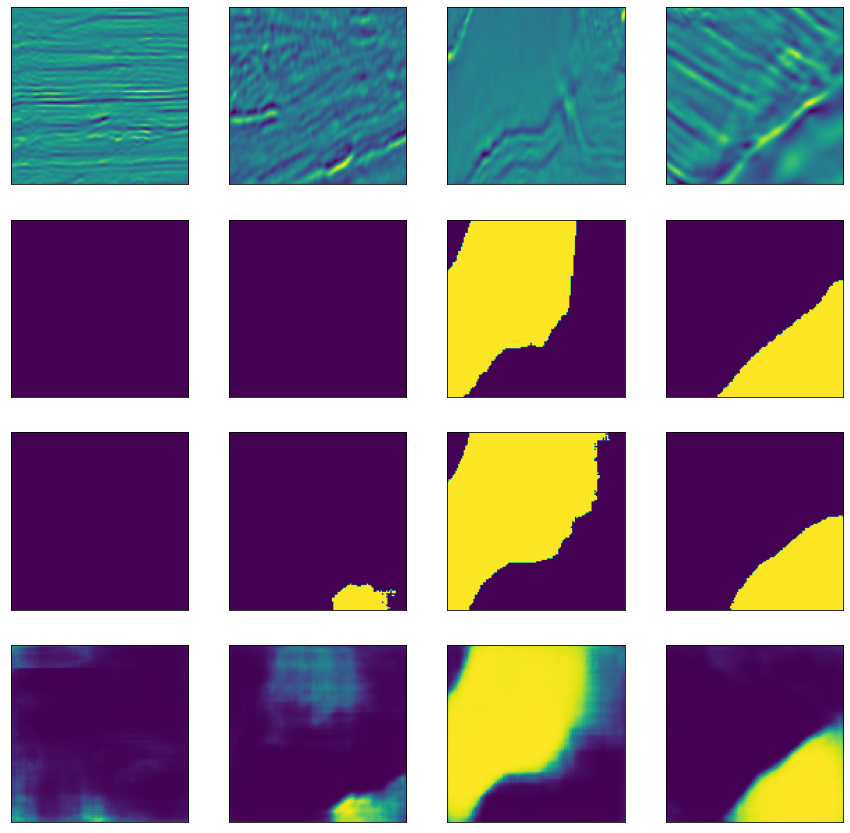

In [41]:
ex_1 =  50#@param {type:"integer"}
ex_2 = 12 #@param {type:"integer"}
ex_3 = 23 #@param {type:"integer"}
ex_4 =  250#@param {type:"integer"}

plt.figure(figsize=(15,15))

plt.subplot(441), plt.imshow(X_valid[ex_1][:,:,0]), plt.xticks([]), plt.yticks([]);
plt.subplot(442), plt.imshow(X_valid[ex_2][:,:,0]), plt.xticks([]), plt.yticks([]);
plt.subplot(443), plt.imshow(X_valid[ex_3][:,:,0]), plt.xticks([]), plt.yticks([]);
plt.subplot(444), plt.imshow(X_valid[ex_4][:,:,0]), plt.xticks([]), plt.yticks([]);

plt.subplot(445), plt.imshow(y_valid[ex_1][:,:,0]), plt.xticks([]), plt.yticks([]);
plt.subplot(446), plt.imshow(y_valid[ex_2][:,:,0]), plt.xticks([]), plt.yticks([]);
plt.subplot(447), plt.imshow(y_valid[ex_3][:,:,0]), plt.xticks([]), plt.yticks([]);
plt.subplot(448), plt.imshow(y_valid[ex_4][:,:,0]), plt.xticks([]), plt.yticks([]);

plt.subplot(449), plt.imshow(np.squeeze(preds_val_t[ex_1])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,10), plt.imshow(np.squeeze(preds_val_t[ex_2])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,11), plt.imshow(np.squeeze(preds_val_t[ex_3])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,12), plt.imshow(np.squeeze(preds_val_t[ex_4])), plt.xticks([]), plt.yticks([]);

plt.subplot(4,4,13), plt.imshow(np.squeeze(preds_val[ex_1])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,14), plt.imshow(np.squeeze(preds_val[ex_2])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,15), plt.imshow(np.squeeze(preds_val[ex_3])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,16), plt.imshow(np.squeeze(preds_val[ex_4])), plt.xticks([]), plt.yticks([]);

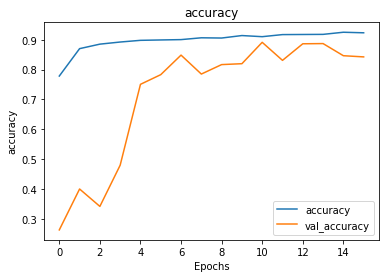

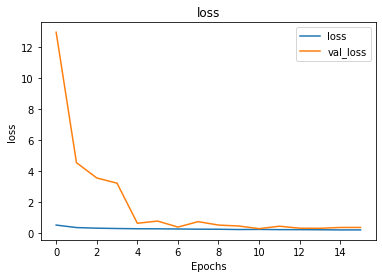

In [42]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.title(string)
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(results, "accuracy")
plot_graphs(results, "loss")

Con el 50% de datos para training se obtiene un buen modelo que permite segmentar las regiones salinas de forma correcta, además, se percibe cómo después de cierta época no varía mucho la pérdida en el modelo. 

## Modelo con 80% de train
A continuación, se vuelven a dividir los datos para repartir nuevamente con 80% para train y poder entrenar el modelo con los mismos.

In [50]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state=42)
input_img = Input((128, 128, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_172 (Conv2D)             (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_163 (BatchN (None, 128, 128, 16) 64          conv2d_172[0][0]                 
__________________________________________________________________________________________________
activation_163 (Activation)     (None, 128, 128, 16) 0           batch_normalization_163[0][0]    
____________________________________________________________________________________________

Se entrena con el 80% de los datos

In [51]:
earlystopper = EarlyStopping(patience=3, verbose=1)
checkpointer = ModelCheckpoint('model_tgs_80train_unet.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, y_train, batch_size=32, 
                    callbacks=[earlystopper, checkpointer],
                    epochs=50,validation_data=(X_valid, y_valid))

Epoch 1/50
100/100 [==============================] - 8s 69ms/step - loss: 0.6228 - accuracy: 0.6455 - val_loss: 10.8788 - val_accuracy: 0.2487

Epoch 00001: val_loss improved from inf to 10.87877, saving model to model_tgs_80train_unet.h5
Epoch 2/50
100/100 [==============================] - 6s 65ms/step - loss: 0.3568 - accuracy: 0.8685 - val_loss: 3.5236 - val_accuracy: 0.3061

Epoch 00002: val_loss improved from 10.87877 to 3.52364, saving model to model_tgs_80train_unet.h5
Epoch 3/50
100/100 [==============================] - 7s 65ms/step - loss: 0.3251 - accuracy: 0.8755 - val_loss: 1.1639 - val_accuracy: 0.5912

Epoch 00003: val_loss improved from 3.52364 to 1.16395, saving model to model_tgs_80train_unet.h5
Epoch 4/50
100/100 [==============================] - 7s 65ms/step - loss: 0.2895 - accuracy: 0.8888 - val_loss: 0.7402 - val_accuracy: 0.7427

Epoch 00004: val_loss improved from 1.16395 to 0.74017, saving model to model_tgs_80train_unet.h5
Epoch 5/50
100/100 [=============

Se define un threshold de 0.7 para mostrar los resultados

In [52]:
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

preds_val.shape, preds_train.shape
# Threshold predictions
preds_train_t = (preds_train > 0.7).astype(np.uint8)
preds_val_t = (preds_val > 0.7).astype(np.uint8)

25/25 [==============================] - 0s 17ms/step


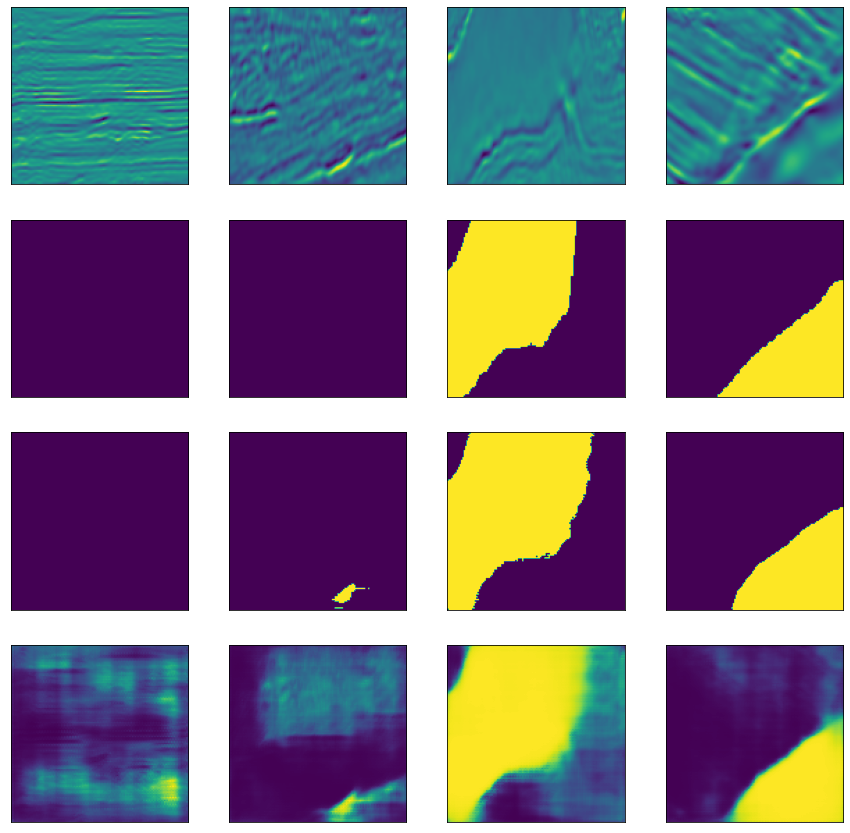

In [53]:
ex_1 =  50#@param {type:"integer"}
ex_2 = 12 #@param {type:"integer"}
ex_3 = 23 #@param {type:"integer"}
ex_4 =  250#@param {type:"integer"}

plt.figure(figsize=(15,15))

plt.subplot(441), plt.imshow(X_valid[ex_1][:,:,0]), plt.xticks([]), plt.yticks([]);
plt.subplot(442), plt.imshow(X_valid[ex_2][:,:,0]), plt.xticks([]), plt.yticks([]);
plt.subplot(443), plt.imshow(X_valid[ex_3][:,:,0]), plt.xticks([]), plt.yticks([]);
plt.subplot(444), plt.imshow(X_valid[ex_4][:,:,0]), plt.xticks([]), plt.yticks([]);

plt.subplot(445), plt.imshow(y_valid[ex_1][:,:,0]), plt.xticks([]), plt.yticks([]);
plt.subplot(446), plt.imshow(y_valid[ex_2][:,:,0]), plt.xticks([]), plt.yticks([]);
plt.subplot(447), plt.imshow(y_valid[ex_3][:,:,0]), plt.xticks([]), plt.yticks([]);
plt.subplot(448), plt.imshow(y_valid[ex_4][:,:,0]), plt.xticks([]), plt.yticks([]);

plt.subplot(449), plt.imshow(np.squeeze(preds_val_t[ex_1])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,10), plt.imshow(np.squeeze(preds_val_t[ex_2])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,11), plt.imshow(np.squeeze(preds_val_t[ex_3])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,12), plt.imshow(np.squeeze(preds_val_t[ex_4])), plt.xticks([]), plt.yticks([]);

plt.subplot(4,4,13), plt.imshow(np.squeeze(preds_val[ex_1])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,14), plt.imshow(np.squeeze(preds_val[ex_2])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,15), plt.imshow(np.squeeze(preds_val[ex_3])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,16), plt.imshow(np.squeeze(preds_val[ex_4])), plt.xticks([]), plt.yticks([]);

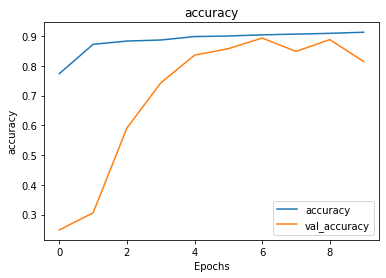

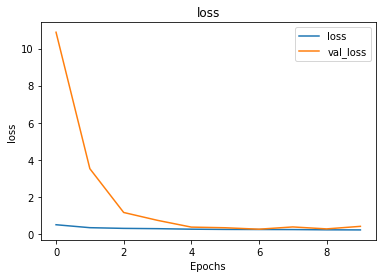

In [56]:
plot_graphs(results, "accuracy")
plot_graphs(results, "loss")

En este caso, se evidencia que lo generado tiene mayor variación y se disminuye la precisión, por lo que se debe aumentar el threshold para mejorar los resultados obtenidos y que se pueda segmentar de forma más similar a los real.

## Modelo con modificaciones a la UNET
Se le hacen ciertas modificaciones a la red implementada para evaluar los resultados y compararlos con los anteriores.
Los datos se dividen en 90% para train y 10% para test.

El principal cambio realizado, es que por cada bloque convolucional, se le agrega una capa concolucional más idéntica a las otra dos, junto con su respectiva capa de batchnormalization; además, se aumentan el número de filtros a 32, se reduce el dropout a 0.04 y se incrementa el batch size a 64.

In [6]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # third layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.9, random_state=42)
input_img = Input((128, 128, 1), name='img')
model = get_unet(input_img, n_filters=32, dropout=0.04, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 128, 128, 32) 320         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_29 (BatchNo (None, 128, 128, 32) 128         conv2d_30[0][0]                  
__________________________________________________________________________________________________
activation_29 (Activation)      (None, 128, 128, 32) 0           batch_normalization_29[0][0]     
____________________________________________________________________________________________

In [17]:
earlystopper = EarlyStopping(patience=4, verbose=1)
checkpointer = ModelCheckpoint('model_tgs_90train_newunet.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, y_train, batch_size=64, 
                    callbacks=[earlystopper, checkpointer],
                    epochs=50,validation_data=(X_valid, y_valid))

Epoch 1/50
57/57 [==============================] - 17s 269ms/step - loss: 0.5915 - accuracy: 0.7058 - val_loss: 5.3474 - val_accuracy: 0.4129

Epoch 00001: val_loss improved from inf to 5.34740, saving model to model_tgs_90train_newunet.h5
Epoch 2/50
57/57 [==============================] - 15s 271ms/step - loss: 0.3270 - accuracy: 0.8790 - val_loss: 3.3496 - val_accuracy: 0.4627

Epoch 00002: val_loss improved from 5.34740 to 3.34965, saving model to model_tgs_90train_newunet.h5
Epoch 3/50
57/57 [==============================] - 15s 268ms/step - loss: 0.2810 - accuracy: 0.8931 - val_loss: 3.0676 - val_accuracy: 0.4554

Epoch 00003: val_loss improved from 3.34965 to 3.06763, saving model to model_tgs_90train_newunet.h5
Epoch 4/50
57/57 [==============================] - 15s 264ms/step - loss: 0.2573 - accuracy: 0.9035 - val_loss: 0.6302 - val_accuracy: 0.7619

Epoch 00004: val_loss improved from 3.06763 to 0.63023, saving model to model_tgs_90train_newunet.h5
Epoch 5/50
57/57 [======

In [30]:
model2 = tf.keras.models.load_model('model_tgs_90train_newunet.h5')

In [45]:
preds_train = model2.predict(X_train, verbose=1)
preds_val = model2.predict(X_valid, verbose=1)

preds_val.shape, preds_train.shape
# Threshold predictions
preds_train_t = (preds_train > 0.6).astype(np.uint8)
preds_val_t = (preds_val > 0.6).astype(np.uint8)

13/13 [==============================] - 0s 40ms/step


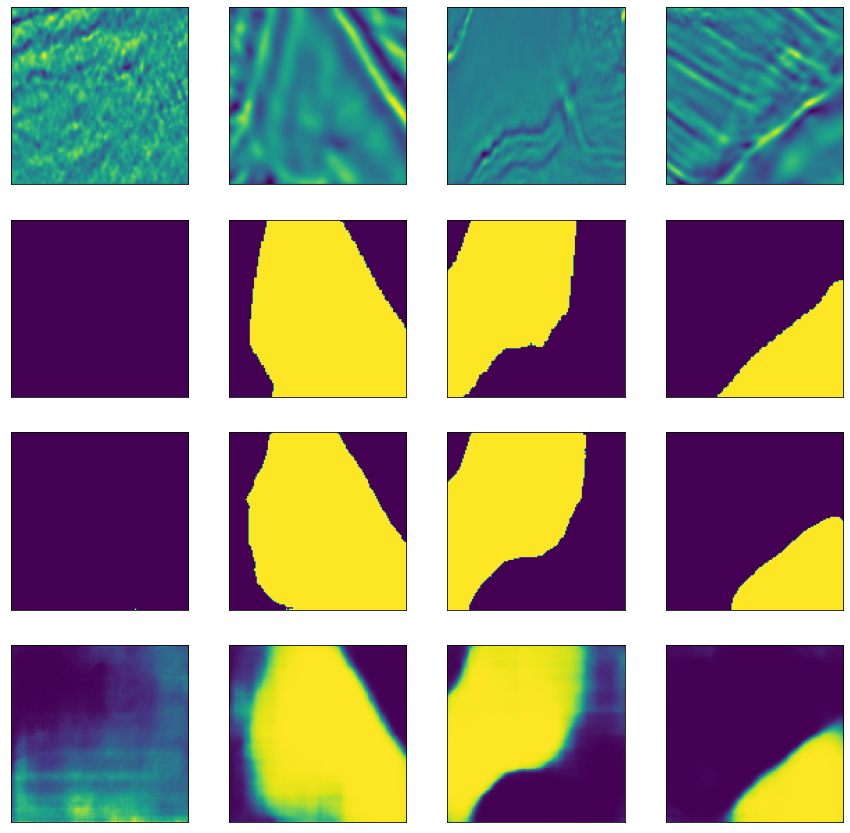

In [46]:
ex_1 =  21#@param {type:"integer"}
ex_2 = 16 #@param {type:"integer"}
ex_3 = 23 #@param {type:"integer"}
ex_4 =  250#@param {type:"integer"}

plt.figure(figsize=(15,15))

plt.subplot(441), plt.imshow(X_valid[ex_1][:,:,0]), plt.xticks([]), plt.yticks([]);
plt.subplot(442), plt.imshow(X_valid[ex_2][:,:,0]), plt.xticks([]), plt.yticks([]);
plt.subplot(443), plt.imshow(X_valid[ex_3][:,:,0]), plt.xticks([]), plt.yticks([]);
plt.subplot(444), plt.imshow(X_valid[ex_4][:,:,0]), plt.xticks([]), plt.yticks([]);

plt.subplot(445), plt.imshow(y_valid[ex_1][:,:,0]), plt.xticks([]), plt.yticks([]);
plt.subplot(446), plt.imshow(y_valid[ex_2][:,:,0]), plt.xticks([]), plt.yticks([]);
plt.subplot(447), plt.imshow(y_valid[ex_3][:,:,0]), plt.xticks([]), plt.yticks([]);
plt.subplot(448), plt.imshow(y_valid[ex_4][:,:,0]), plt.xticks([]), plt.yticks([]);

plt.subplot(449), plt.imshow(np.squeeze(preds_val_t[ex_1])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,10), plt.imshow(np.squeeze(preds_val_t[ex_2])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,11), plt.imshow(np.squeeze(preds_val_t[ex_3])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,12), plt.imshow(np.squeeze(preds_val_t[ex_4])), plt.xticks([]), plt.yticks([]);

plt.subplot(4,4,13), plt.imshow(np.squeeze(preds_val[ex_1])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,14), plt.imshow(np.squeeze(preds_val[ex_2])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,15), plt.imshow(np.squeeze(preds_val[ex_3])), plt.xticks([]), plt.yticks([]);
plt.subplot(4,4,16), plt.imshow(np.squeeze(preds_val[ex_4])), plt.xticks([]), plt.yticks([]);

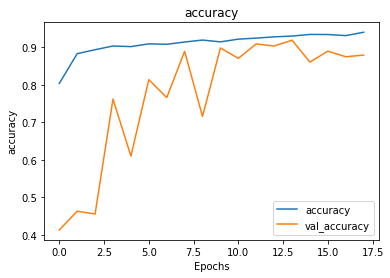

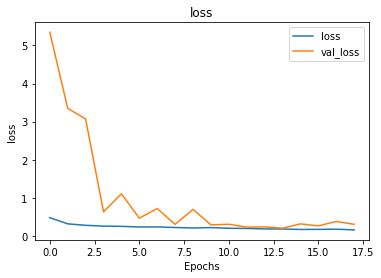

In [28]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.title(string)
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
plot_graphs(results, "accuracy")
plot_graphs(results, "loss")

Al obtener el modelo con la menor pérdida, se observa que se obtiene un buen resultado para la segmentación, aunque con algunos pequeños matices y ciertas imperfecciones. Fue necesario colocar un threshdold de 0.6. Además, entre los 3 modelos entrenados, este obtuvo la menor pérdida.

# **3. Enjoy GANS: Build new Pokemons**

You should implement a GAN arhictecture to generate new cars. Please load and work with nex dataset: [dataset](https://www.kaggle.com/dollarakshay/pokemon-images). Please change orginal version, using more convolutional layers and for more than 100 ephocs. 

- Display the results for each of trained epochs. 



## Carga de datos

In [ ]:
!kaggle datasets download -d dollarakshay/pokemon-images
!unzip pokemon-images.zip 

pokemon-images.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  pokemon-images.zip
  inflating: POKEMON/0001.png        
  inflating: POKEMON/0002.png        
  inflating: POKEMON/0003.png        
  inflating: POKEMON/0004.png        
  inflating: POKEMON/0005.png        
  inflating: POKEMON/0006.png        
  inflating: POKEMON/0007.png        
  inflating: POKEMON/0008.png        
  inflating: POKEMON/0009.png        
  inflating: POKEMON/0010.png        
  inflating: POKEMON/0011.png        
  inflating: POKEMON/0012.png        
  inflating: POKEMON/0013.png        
  inflating: POKEMON/0014.png        
  inflating: POKEMON/0015.png        
  inflating: POKEMON/0016.png        
  inflating: POKEMON/0017.png        
  inflating: POKEMON/0018.png        
  inflating: POKEMON/0019.png        
  inflating: POKEMON/0020.png        
  inflating: POKEMON/0021.png        
  inflating: POKEMON/0022.png        
  inflating: POKEMON/0023.png    

Se borra una carpeta repetida

In [ ]:
!rm -r POKEMON/POKEMON

Se crea la función del modelo generador con una capa densa y tres de convolución transpuesta.

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 230400)            23040000  
_________________________________________________________________
batch_normalization_45 (Batc (None, 230400)            921600    
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 230400)            0         
_________________________________________________________________
reshape_6 (Reshape)          (None, 30, 30, 256)       0         
_________________________________________________________________
conv2d_transpose_21 (Conv2DT (None, 30, 30, 128)       819200    
_________________________________________________________________
batch_normalization_46 (Batc (None, 30, 30, 128)       512       
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 30, 30, 128)     

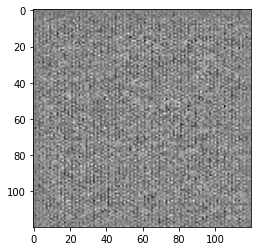

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    
    n = 120 // 4
    
    model.add(layers.Dense(n * n * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((n, n, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))


    model.summary()

    return model

generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

Se crea la función del modelo discriminador con dos capas convolucionales y la última capa densa

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(120, 120, 3)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    model.summary()

    return model

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)


Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 60, 60, 64)        4864      
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 60, 60, 64)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 60, 60, 64)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 30, 30, 128)       204928    
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 30, 30, 128)       0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 30, 30, 128)       0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 115200)          

Se definen las pérdidas para cada modelo

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

!mkdir training_checkpoints gans_ep
checkpoint_dir = 'training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

mkdir: cannot create directory ‘training_checkpoints’: File exists
mkdir: cannot create directory ‘gans_ep’: File exists


Se corre el modelo con 5000 épocas, se define la dimensión del ruido en 100 y la cantidad de imágenes a generar en 16.

In [ ]:
#@title **code** Defining the training loop
EPOCHS =  5000#@param {type:"integer"}
noise_dim = 100#@param {type:"integer"}
num_examples_to_generate = 16#@param {type:"integer"}

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

Se crea la función para cada paso del entrenamiento de la red de forma manual.

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

Se crea la función para el entrenamiento completo de la red de acuerdo a las épocas. Se guarda un checkpoint cada 200 épocas.

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 200 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

Se define la función para crear cada imagen, y se guardan estas cada 100 épocas para no llenar el disco.

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(10,10))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      if predictions.shape[-1] == 3:
        plt.imshow(predictions[i] * 0.5 + .5)  # scale image to [0, 1] floats 
      else: 
        plt.imshow(predictions[i, :, :, 0] * 0.5 + .5, cmap='gray')  # scale image to [0, 1] 
      plt.axis('off')

  if epoch % 100 == 0:
    plt.savefig('gans_ep/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

def display_image(epoch_no):
  return PIL.Image.open('gans_ep/image_at_epoch_{:04d}.png'.format(epoch_no))

Se le hace el preprocesamiento a cada imagen, haciéndole un rezise a 120x120 y un escalado de los valores entre -1 y 1

In [ ]:
def preprocess(file_path):
    # load the raw data from the file as a string
    imgs=[]
    for i in os.listdir(file_path):
      img = tf.io.read_file(file_path+"/"+i)
      # load the image as uint8 array and transform to grayscale
      img = tf.image.decode_jpeg(img, channels=3)
      # resize the image to the desired size
      img = tf.image.resize(img, [120, 120])
      # transform the color values from [0, 255] to [-1, 1] and to float32
      img = (img - 127.5) / 127.5
      imgs.append(img)
    return imgs

train_dataset0 = preprocess("POKEMON")

Se realiza el entrenamiento.

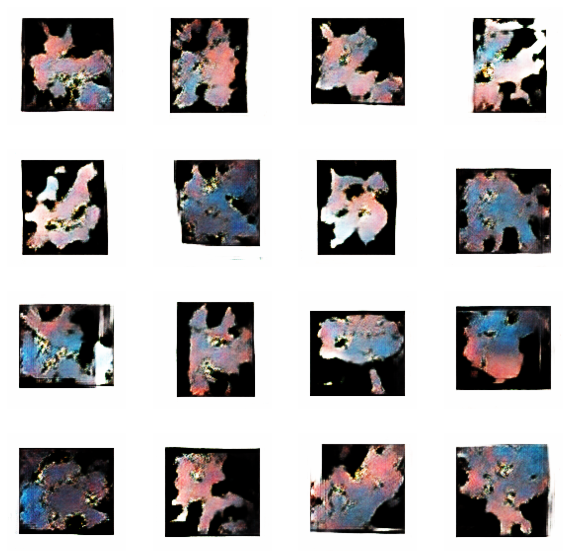

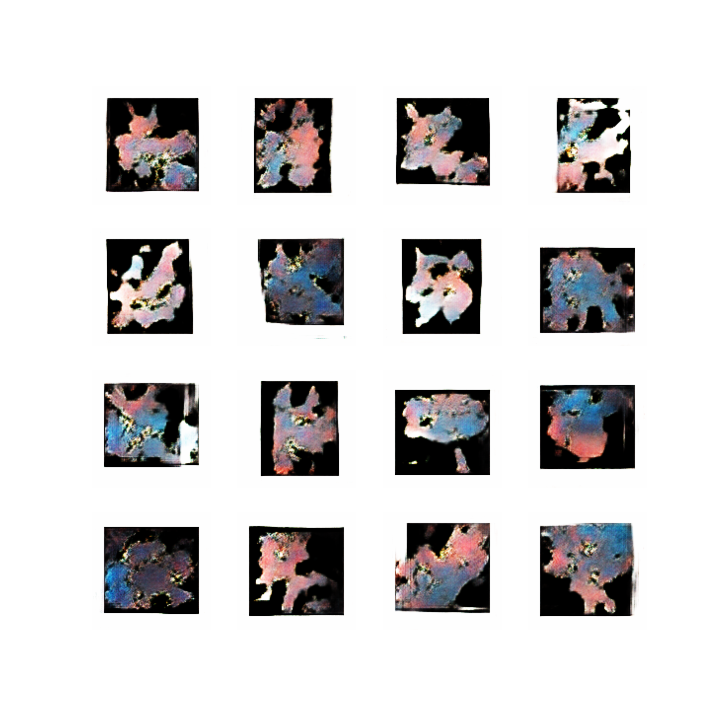

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset0).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train(train_dataset, EPOCHS)
display_image(EPOCHS)

Se observa que las imágenes tienden a obtener una forma de la cual se podrían tener pokémons; sin embargo, la red no es capaz de mostrar colocres adecuados para cada parte de los mismos.


<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/cv/cv-uis-student/raw/master/imgs/bannerThanks.jpg" style="width:1000px;">